In [1]:
#Informasi Dataset
#https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/data

In [2]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('online_retail_II.csv')

In [4]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [5]:
df.shape

(1067371, 8)

In [6]:
#cek missing values

print(df.isnull().sum())

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [7]:
#drop nilai null

df = df.dropna(subset=['Customer ID'])
df = df.drop(columns=['Description'])

In [8]:
df.shape

(824364, 7)

In [9]:
#menghitung nilai totalsales
df['TotalSales'] = df['Quantity'] * df['Price']

In [10]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [11]:
print("Jumlah data setelah hapus cancellation:", df.shape)

Jumlah data setelah hapus cancellation: (805620, 8)


In [12]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [13]:
print("Jumlah data setelah hapus return dan cek outlier:", df.shape)

Jumlah data setelah hapus return dan cek outlier: (805549, 8)


In [14]:
#konversi invoicedate ke datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
#dataset setelah cleaning dan sudah valid
df.head(10)

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [16]:
#buat tabel RFM (recency, frequency, monetary)
import datetime as dt

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print("Reference Date:", reference_date)

Reference Date: 2011-12-10 12:50:00


In [17]:
#hitung RFM
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSales': 'sum'
})

#rename kolom
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [18]:
#normalisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [19]:
#clustering
from sklearn.cluster import KMeans

#cari jumlah cluster (using elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,326,12,77556.46,0
12347.0,2,8,5633.32,0
12348.0,75,5,2019.40,0
12349.0,19,4,4428.69,0
12350.0,310,1,334.40,1


In [20]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,67.005728,7.307732,3009.402451
1,463.032032,2.212212,765.244446
2,3.500000,212.500000,436835.792500
3,25.942857,103.714286,83086.079771


In [21]:
#intepretasi cluster
#cluster 0 = pelanggan dengan recency kecil (baru belanja), frequency & monetary tinggi → Loyal / VIP Customers.
#cluster 1 = recency tinggi (lama tidak belanja), frequency rendah → Lost Customers.
#cluster 2 = frequency menengah, monetary moderat → Potential Customers.
#cluster 3 = pelanggan sekali beli → One-time Buyers.

         Recency  Frequency   Monetary  Customers
Cluster                                          
0          67.01       7.31    3009.40       3841
1         463.03       2.21     765.24       1998
2           3.50     212.50  436835.79          4
3          25.94     103.71   83086.08         35


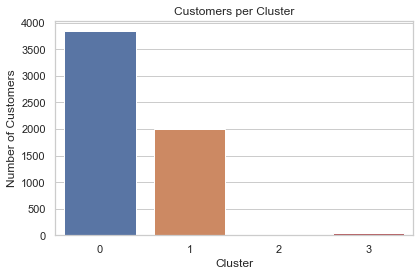

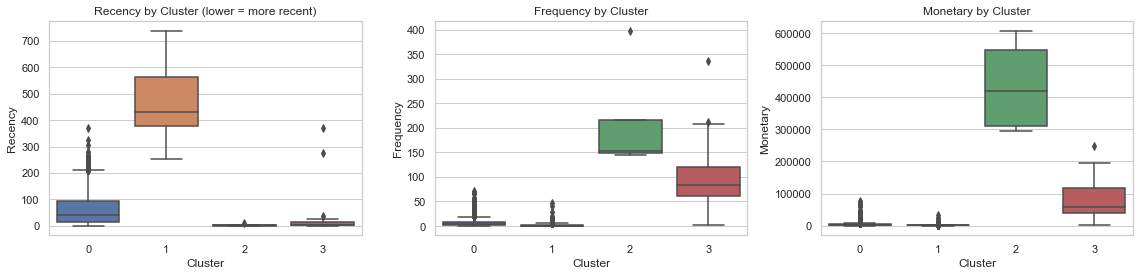

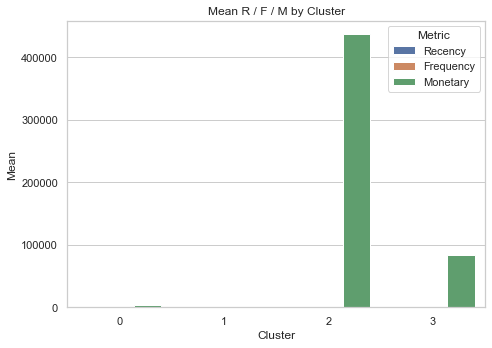

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan tipe dan setelan dasar
rfm = rfm.dropna(subset=['Cluster']).copy()
rfm['Cluster'] = rfm['Cluster'].astype('category')
sns.set(style="whitegrid", font_scale=1.0)

# 1) PROFIL SEGMENTASI: mean R/F/M + count per cluster
profile = (
    rfm.groupby('Cluster')[['Recency','Frequency','Monetary']]
       .mean()
       .round(2)
    .assign(Customers = rfm.groupby('Cluster').size())
)
print(profile)

# 2) JUMLAH PELANGGAN PER CLUSTER (barplot)
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='Cluster')
plt.title('Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# 3) BOX PLOTS: distribusi R/F/M per cluster
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.boxplot(data=rfm, x='Cluster', y='Recency', ax=axes[0])
axes[0].set_title('Recency by Cluster (lower = more recent)')

sns.boxplot(data=rfm, x='Cluster', y='Frequency', ax=axes[1])
axes[1].set_title('Frequency by Cluster')

sns.boxplot(data=rfm, x='Cluster', y='Monetary', ax=axes[2])
axes[2].set_title('Monetary by Cluster')

plt.tight_layout()
plt.show()

# 4) BAR PLOT MEAN R/F/M per cluster (mudah dibaca manajemen)
profile_melt = (
    rfm.groupby('Cluster')[['Recency','Frequency','Monetary']]
       .mean()
       .reset_index()
       .melt(id_vars='Cluster', var_name='Metric', value_name='Mean')
)

plt.figure(figsize=(7,5))
sns.barplot(data=profile_melt, x='Cluster', y='Mean', hue='Metric')
plt.title('Mean R / F / M by Cluster')
plt.tight_layout()
plt.show()

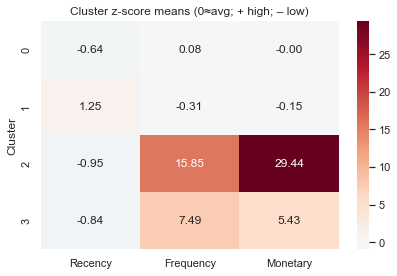

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
z = pd.DataFrame(sc.fit_transform(rfm[['Recency','Frequency','Monetary']]),
                 columns=['Recency','Frequency','Monetary'], index=rfm.index)
z['Cluster'] = rfm['Cluster'].values
z_mean = z.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)

plt.figure(figsize=(6,4))
sns.heatmap(z_mean, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Cluster z-score means (0≈avg; + high; – low)')
plt.tight_layout()
plt.show()


In [24]:
# Asumsi rfm punya kolom 'Cluster'
prof = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# Rank: Recency ascending (kecil = baik), Frequency & Monetary descending (besar = baik)
prof['R_rank'] = prof['Recency'].rank(ascending=True,  method='dense')
prof['F_rank'] = prof['Frequency'].rank(ascending=False, method='dense')
prof['M_rank'] = prof['Monetary'].rank(ascending=False, method='dense')

# Skor gabungan untuk menentukan High vs Low
prof['Score'] = prof['R_rank'] + prof['F_rank'] + prof['M_rank']

# Tentukan cluster utama
high_cluster   = prof['Score'].idxmax()                                # terbaik total
low_cluster    = prof['Score'].idxmin()                                # terlemah total
at_risk_cluster= prof.sort_values(['Recency','Frequency'],
                                  ascending=[False, True]).index[0]    # recency terburuk & freq rendah

# Default label
prof['Segment'] = 'Medium Value'
prof.loc[high_cluster, 'Segment'] = 'High Value'
prof.loc[low_cluster,  'Segment'] = 'Low Value'
prof.loc[at_risk_cluster, 'Segment'] = 'At Risk'

# Map balik ke setiap customer
rfm['Segment'] = rfm['Cluster'].map(prof['Segment'])

print(prof[['Recency','Frequency','Monetary','Score','Segment']].round(2))
print(rfm['Segment'].value_counts())


         Recency  Frequency   Monetary  Score       Segment
Cluster                                                    
0          67.01       7.31    3009.40    9.0  Medium Value
1         463.03       2.21     765.24   12.0       At Risk
2           3.50     212.50  436835.79    3.0     Low Value
3          25.94     103.71   83086.08    6.0  Medium Value
Medium Value    3876
At Risk         1998
Low Value          4
Name: Segment, dtype: int64


Medium Value    3876
At Risk         1998
Low Value          4
Name: Segment, dtype: int64


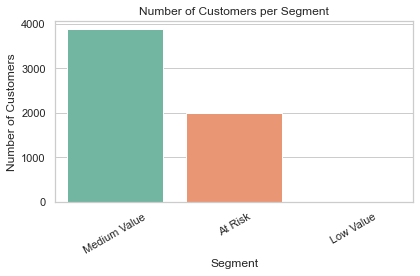

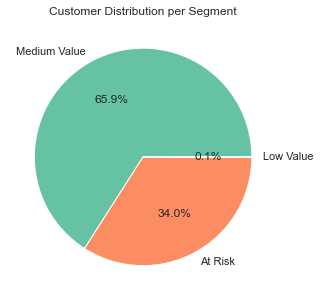

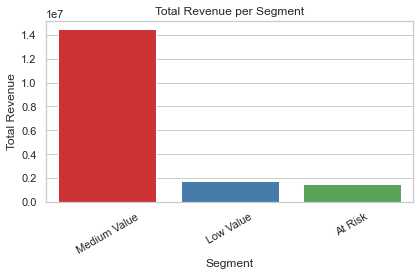

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom Segment sudah ada
print(rfm['Segment'].value_counts())

# 1) Jumlah pelanggan per segmen
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="Set2")
plt.title("Number of Customers per Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# (Opsional) pie chart
rfm['Segment'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(5,5), colors=sns.color_palette("Set2"))
plt.title("Customer Distribution per Segment")
plt.ylabel("")
plt.show()

# 2) Total revenue per segmen
revenue_per_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=revenue_per_segment.index, y=revenue_per_segment.values, palette="Set1")
plt.title("Total Revenue per Segment")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [26]:
# Hitung ringkasan per segmen
summary = rfm.groupby('Segment').agg(
    Customers = ('Segment','count'),
    Revenue   = ('Monetary','sum')
).reset_index()

# Hitung persentase
total_customers = summary['Customers'].sum()
total_revenue   = summary['Revenue'].sum()

summary['% Customers'] = (summary['Customers'] / total_customers * 100).round(2)
summary['% Revenue']   = (summary['Revenue'] / total_revenue * 100).round(2)

# Urutkan berdasarkan revenue (opsional)
summary = summary.sort_values(by='Revenue', ascending=False)

print(summary)


        Segment  Customers       Revenue  % Customers  % Revenue
2  Medium Value       3876  1.446713e+07        65.94      81.54
1     Low Value          4  1.747343e+06         0.07       9.85
0       At Risk       1998  1.528958e+06        33.99       8.62


In [27]:
df.shape

(805549, 8)